In [1]:
!pip install pm4py

In [2]:
import pm4py
import pandas

In [3]:
# Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# import log
from pm4py.objects.log.importer.xes import importer as xes_importer
# log from here https://www.futurelearn.com/info/courses/process-mining/0/steps/15620
log_xes2 = xes_importer.apply('/content/gdrive/MyDrive/Курс 2/Проект/logs/Artificial - Repair.xes')

parsing log, completed traces ::   0%|          | 0/1104 [00:00<?, ?it/s]

In [5]:
# discover a net
from pm4py.visualization.petri_net import visualizer as pn_visualizer
# full
new_net, init_marking, final_marking = pm4py.discover_petri_net_inductive(log_xes2)
viz = pn_visualizer.apply(new_net, init_marking, final_marking)
viz
pn_visualizer.save(viz, 'full_net.png')

# Change the Net (functions)
здесь возможно изобретение целого ряда велосипедов

In [6]:
from pm4py.objects.petri_net.obj import PetriNet, Marking

def del_arc(source_name, target_name, net):
  bad_arc = None
  for arc in net.arcs:
    match_source = (source_name == arc.source.name)
    if isinstance(arc.source, PetriNet.Transition):
      match_source = match_source or (source_name == arc.source.label)
    match_target = (target_name == arc.target.name)
    if isinstance(arc.target, PetriNet.Transition):
      match_target = match_target or (target_name == arc.target.label)

    if match_source and match_target:
      bad_arc = arc
  
  if bad_arc is None:
    return

  print('removed', bad_arc)

  for pl in net.places:
    if bad_arc in pl.in_arcs:
      pl.in_arcs.remove(bad_arc)
    if bad_arc in pl.out_arcs:
      pl.out_arcs.remove(bad_arc)

  for tr in net.transitions:
    if bad_arc in tr.in_arcs:
      tr.in_arcs.remove(bad_arc)
    if bad_arc in tr.out_arcs:
      tr.out_arcs.remove(bad_arc)

  net.arcs.remove(bad_arc)

def del_trans(label, net):
  for trans in net.transitions:
    if (trans.label == label or trans.name == label):
      print('delete', trans)
      net.transitions.remove(trans)
      return
  return

def del_place(label, net):
  for place in net.places:
    if (place.name == label):
      print('delete', place)
      net.places.remove(place)
      return
  return

def create_arc(source_name, target_name, net):
  source = None
  target = None

  for place in net.places:
    if (place.name == source_name):
      source = place
    if (place.name == target_name):
      target = place
  
  for trans in net.transitions:
    if (trans.label == source_name):
      source = trans
    if (trans.label == target_name):
      target = trans
  
  if source is None or target is None:
    return
  # print(source, target)
  arc = PetriNet.Arc(source, target, 1)
  if arc in net.arcs:
    return
  print('created', arc)
  net.arcs.add(arc)

# by name
def copy_marking(marking, net):
  new_marking = Marking()
  for pl in marking:
    for new_net_pl in net.places:
      if (pl.name == new_net_pl.name):
        new_marking[new_net_pl] = marking[pl]
  return new_marking

# Worsen the net

In [7]:
from copy import deepcopy

custom_net = deepcopy(new_net)
custom_init_marking = copy_marking(init_marking, custom_net)
custom_final_marking = copy_marking(final_marking, custom_net)

removed p_20->(skip_15, None)
removed p_20->(skip_16, None)
removed (skip_16, None)->p_18
removed (96209ee0-51c8-47ec-afac-12d7ac7f98be, 'Test Repair')->p_20
removed (skip_15, None)->p_19
removed p_19->(96209ee0-51c8-47ec-afac-12d7ac7f98be, 'Test Repair')
removed (init_loop_13, None)->p_19
removed p_17->(init_loop_13, None)
delete (init_loop_13, None)
delete (96209ee0-51c8-47ec-afac-12d7ac7f98be, 'Test Repair')
delete (skip_15, None)
delete (skip_16, None)
delete p_19
delete p_20
created (1fbc4630-de4d-48a2-9259-47e67ea5bd5b, 'Repair (Complex)')->p_16
removed (1fbc4630-de4d-48a2-9259-47e67ea5bd5b, 'Repair (Complex)')->p_17


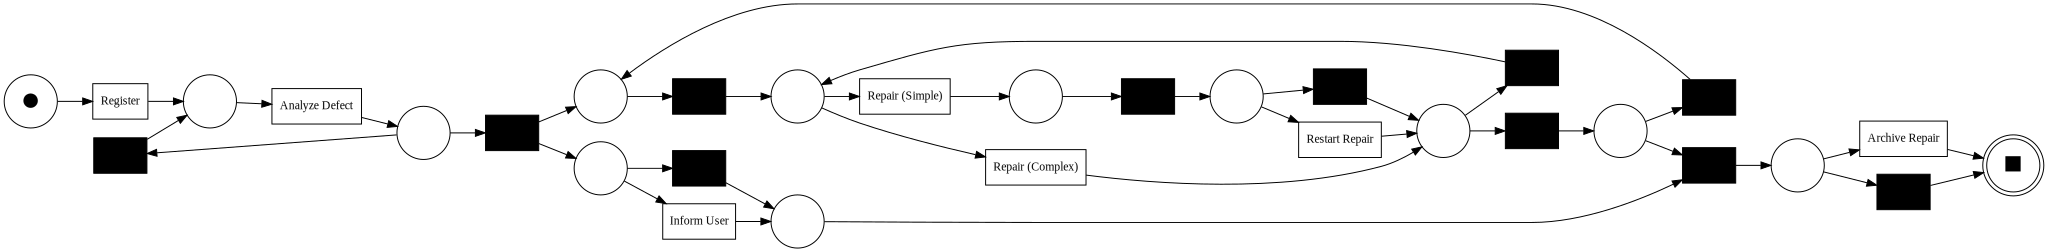

In [8]:
# skip 'restart repair'
del_arc('p_20', 'skip_15', custom_net)
del_arc('p_20', 'skip_16', custom_net)

del_arc('skip_16', 'p_18', custom_net)
del_arc('Test Repair', 'p_20', custom_net)
del_arc('skip_15', 'p_19', custom_net)
del_arc('p_19', 'Test Repair', custom_net)

del_arc('skip_16', 'p_18', custom_net)
del_arc('init_loop_13', 'p_19', custom_net)
del_arc('p_17', 'init_loop_13', custom_net)

del_trans('init_loop_13', custom_net)
del_trans('Test Repair', custom_net)
del_trans('skip_15', custom_net)
del_trans('skip_16', custom_net)
del_place('p_19', custom_net)
del_place('p_20', custom_net)

create_arc('Repair (Complex)', 'p_16', custom_net)
del_arc('Repair (Complex)', 'p_17', custom_net)
###
pn_visualizer.apply(custom_net, custom_init_marking, custom_final_marking)

# Functions for debug and visualization

In [9]:
def print_my_marking(marking):
  for place, tokens in marking.items():
    if not tokens:
      continue
    print(f'in place {place}: ')
    for token in tokens:
      print(f'\tdirect ancestors = {token.direct_ancestors}')

In [10]:
from pm4py.visualization.petri_net.common import visualize
from copy import copy
from copy import deepcopy

def visualize_pairs(bad_segs_pairs, net, initial_marking, final_marking):
  custom_net = deepcopy(net)
  init_marking = copy_marking(initial_marking, custom_net)
  final_marking = copy_marking(final_marking, custom_net)
  """
  transition: {'color': ***, 'label': ***}
  """
  decorations = {}
  transitions_map = {}
  for trans in custom_net.transitions:
    transitions_map[trans.label] = trans

  decorations = {}
  i = 0
  tot_pairs_cnt = sum([cnt for pair_name, cnt in bad_segs_pairs.items()])

  for pair, cnt in bad_segs_pairs.items():
    st, end = pair
    i += 1
    st = transitions_map[st]
    end = transitions_map[end]
    
    # print(f'{st} -> {end}')

    p = PetriNet.Place(f'pair{i}')
    custom_net.places.add(p)
    arc1 = PetriNet.Arc(st, p, 1)
    arc2 = PetriNet.Arc(p, end, 1)
    custom_net.arcs.add(arc1)
    custom_net.arcs.add(arc2)

    decorations[arc1] = {'color' : f'0.000 {0.5 + cnt / (2*tot_pairs_cnt)} 1.000'}
    decorations[arc2] = {'color' : f'0.000 {0.5 + cnt / (2*tot_pairs_cnt)} 1.000'}
    decorations[p] = {'color' : f'0.000 {0.5 + cnt / (2*tot_pairs_cnt)} 1.000', 'label' : ''}
  
  return visualize.apply(custom_net, init_marking, final_marking, decorations=decorations)

# Finding the bad pairs

In [11]:
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments
parameters = {alignments.Variants.VERSION_STATE_EQUATION_A_STAR.value.Parameters.PARAM_ALIGNMENT_RESULT_IS_SYNC_PROD_AWARE: True}
aligned_traces = alignments.apply_log(log_xes2, custom_net, custom_init_marking, custom_final_marking, parameters=parameters)

aligning log, completed variants ::   0%|          | 0/77 [00:00<?, ?it/s]

In [12]:
def format_alignment(alignment):
  '''
  'log': labels
  'model': (label, name)
  '''
  log_steps = [labels[0] for names, labels in alignment]
  model_steps = [(labels[1], names[1]) for names, labels in alignment]
  data = {'log' : log_steps, 'model' : model_steps}
  return data

In [13]:
class my_token:
  def __init__(self):
    self.direct_ancestors = set()  # just ancestors
    self.red_ancestors = set()    # ancestors before bad transitions
    # self.moved_as_red = False
    # self.color = 'white'

In [16]:
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
from copy import copy

DEBUG = False

def find_bad_pairs(net: PetriNet, alignment, initial_marking):
  '''
  alignment for one trace
            must be formatted
  '''

  bad_pairs = {}  # pair : cnt

  marking = {} # place -> [tokens]
  for plc in net.places:
    marking[plc] = []

  for place, cnt in initial_marking.items():
    marking[place] = [my_token()] * cnt

  if DEBUG:
    print_my_marking(marking)

  for i in range(len(alignment['model'])):
    model_label, model_name = alignment['model'][i]
    log_label = alignment['log'][i]

    if model_label != '>>':   # fired transition
      # find transition
      fired_transition = None
      for t in net.transitions:
        if t.name == model_name:
          fired_transition = t
          break
      if DEBUG:
        print(f'fired transition: {fired_transition}')
      
      consumed_tokens = []
      # consume tokens
      for in_arc in fired_transition.in_arcs:
        in_plc = in_arc.source
        consumed_tokens.append(marking[in_plc].pop(0))

      # unite lists
      union_token = my_token()
      for token in consumed_tokens:
        union_token.red_ancestors = set.union(union_token.red_ancestors, token.red_ancestors)
        union_token.direct_ancestors = set.union(union_token.direct_ancestors, token.direct_ancestors)

      if model_label is None:         # hidden transition
        # just save the condition
        pass
      elif model_label == log_label:  # sync move
        for red_ancestor in union_token.red_ancestors: # add a pair of transitions
          pair = (red_ancestor, fired_transition.label)
          if DEBUG:
            print(f'added bad pair:\t{pair}')
          if pair in bad_pairs:
            bad_pairs[pair] += 1
          else:
            bad_pairs[pair] = 1
        union_token.red_ancestors = set()
        union_token.direct_ancestors = set([fired_transition.label])
      elif log_label == '>>':         # model-only move
        union_token.red_ancestors = set.union(union_token.red_ancestors, union_token.direct_ancestors)

      # produce tokens
      for out_arc in fired_transition.out_arcs:
        out_plc = out_arc.target
        marking[out_plc].append(copy(union_token))

      if DEBUG:
        print_my_marking(marking)
    else: # log-only move
      pass

  return bad_pairs

In [17]:
bad_pairs = {}

for aligned_trace in aligned_traces:
  alignment = format_alignment(aligned_trace['alignment'])
  cur_bad_pairs = find_bad_pairs(custom_net, alignment, custom_init_marking)
  for plc, cnt in cur_bad_pairs.items():
    if plc in bad_pairs:
      bad_pairs[plc] += cnt
    else:
      bad_pairs[plc] = cnt

In [18]:
viz = visualize_pairs(bad_pairs, custom_net, custom_init_marking, custom_final_marking)
pn_visualizer.save(viz, 'bad_pairs.png')
# "плохая" пара будет выделена с помощью добавленной красной позиции и рёбер, соединяющих вершины пары с ней